# Omnimodal assistant with Qwen2.5-Omni and OpenVINO

Qwen2.5-Omni is an end-to-end multimodal model designed to perceive diverse modalities, including text, images, audio, and video, while simultaneously generating text and natural speech responses in a streaming manner.

![Image](https://github.com/user-attachments/assets/600798db-c80e-4d1d-ab00-fa945cdcd583)

More details about model can be found in [model card](https://huggingface.co/Qwen/Qwen2.5-Omni-7B) and original [repo](https://github.com/QwenLM/Qwen2.5-Omni).

In this tutorial we consider how to convert and optimize Qwen2.5-Omni model for creating omnimodal chatbot. Additionally, we demonstrate how to apply stateful transformation on LLM part and model optimization techniques like weights compression using [NNCF](https://github.com/openvinotoolkit/nncf)

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert model to OpenVINO Intermediate Representation](#Convert-model-to-OpenVINO-Intermediate-Representation)
    - [Compress Language Model Weights to 4 bits](#Compress-Language-Model-Weights-to-4-bits)
- [Prepare model inference pipeline](#Prepare-model-inference-pipeline)
    - [Select device](#Select-device)
    - [Initialize model tasks](#Initialize-model-tasks)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Text-only input and Audio output](#Text-only-input-and-Audio-output)
    - [Text-Image input](#Text-Image-input)
    - [Audio-Text input](#Audio-Text-input)
    - [Video-text input](#Video-text-input)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).


<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/qwen2.5-omni-chatbot/qwen2.5-omni-chatbot.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import requests
from pathlib import Path

if not Path("qwen2_5_omni_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/qwen2.5-omni-chatbot/qwen2_5_omni_helper.py")
    open("qwen2_5_omni_helper.py", "w").write(r.text)


if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/qwen2.5-omni-chatbot/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

if not Path("pip_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/pip_helper.py",
    )
    open("pip_helper.py", "w").write(r.text)

from pip_helper import pip_install


pip_install(
    "transformers==4.52.0",
    "torchvision",
    "accelerate",
    "qwen-omni-utils[decord]",
    "gradio>=4.19",
    "--no-cache-dir",
    "--extra-index-url",
    "https://download.pytorch.org/whl/cpu",
)
pip_install("openvino==2025.1.0", "nncf>=2.16.0")

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("qwen2.5-omni-chatbot.ipynb")

## Convert model to OpenVINO Intermediate Representation
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

`qwen2.5_omni_helper.py` script contains helper function for model conversion, please check its content if you interested in conversion details.


Qwen2.5-Omni employs Thinker-Talker architecture. Thinker functions like a brain, responsible for processing and understanding inputs from text, audio and video modalities, generating high-level representations and corresponding text. Talker operates like a human mouth, taking in the high-level representations and text produced by the Thinker in a streaming manner, and outputting discrete tokens of speech fluidly. Thinker is a Transformer decoder, accompanied by encoders for audio and image that facilitate information extraction. In contrast, Talker is designed as a dual-track autoregressive Transformer Decoder architecture. During both training and inference, Talker directly receives high-dimensional representations from Thinker and shares all of Thinker’s historical context information. Consequently, the entire architecture operates as a cohesive single model, enabling end-to-end training and inference.

Let's convert each model part.

In [ ]:
import ipywidgets as widgets

model_ids = ["Qwen/Qwen2.5-Omni-3B", "Qwen/Qwen2.5-Omni-7B"]

model_id = widgets.Dropdown(
    options=model_ids,
    default=model_ids[0],
    description="Model:",
)

model_id

Dropdown(description='Model:', options=('Qwen/Qwen2.5-Omni-3B', 'Qwen/Qwen2.5-Omni-7B'), value='Qwen/Qwen2.5-O…

In [ ]:
model_id = model_id.value
model_dir = Path(model_id.split("/")[-1])

### Compress Thinker and Talker Model Weights to 4 bits
[back to top ⬆️](#Table-of-contents:)

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf).

<details>
    <summary><b>Click here for more details about weight compression</b></summary>
Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).

</details>

> **Note:** weights compression process may require additional time and memory for performing. You can disable it using widget below:

In [ ]:
import nncf
from qwen2_5_omni_helper import convert_qwen2_5_omni_model

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_ASYM,
    "group_size": 128,
    "ratio": 0.8,
}

convert_qwen2_5_omni_model(model_id, model_dir, compression_configuration)

✅ Qwen/Qwen2.5-Omni-3B model already converted. You can find results in Qwen2.5-Omni-3B


## Prepare model inference pipeline
[back to top ⬆️](#Table-of-contents:)

As discussed, the model comprises Image Encoder and LLM (with separated text embedding part) that generates answer. In `qwen2_5_omni_helper.py` we defined Thinker inference class `OVQwen2_5OmniThinkerForConditionalGeneration` and Talker inference class `OVQwen2_5OmniTalkerForConditionalGeneration` that will represent generation cycle, It is based on [HuggingFace Transformers `GenerationMixin`](https://huggingface.co/docs/transformers/main_classes/text_generation) and looks similar to [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) `OVModelForCausalLM`that is used for LLM inference with only difference that it can accept input embedding. In own turn, general multimodal model class `OVQwen2_5OmniModel` handles chatbot functionality including image processing and answer generation using LLM.

### Select device
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from notebook_utils import device_widget

thinker_device = device_widget(default="AUTO", exclude=["NPU"], description="Thinker device")

thinker_device

Dropdown(description='Thinker device', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [ ]:
talker_device = device_widget(default="AUTO", exclude=["NPU"], description="Talker device")

talker_device

Dropdown(description='Talker device', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [ ]:
token2wav_device = device_widget(default="CPU", exclude=["NPU"], description="Token2Wav device")

token2wav_device

Dropdown(description='Token2Wav device', options=('CPU', 'AUTO'), value='CPU')

### Initialize model tasks
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from qwen2_5_omni_helper import OVQwen2_5OmniModel
from transformers import Qwen2_5OmniProcessor

ov_model = OVQwen2_5OmniModel(model_dir, thinker_device=thinker_device.value, talker_device=talker_device.value, token2wav_device=token2wav_device.value)
processor = Qwen2_5OmniProcessor.from_pretrained(model_dir)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


## Run model inference
[back to top ⬆️](#Table-of-contents:)

Let's explore model capabilities using multimodal input and output.

In [ ]:
from qwen_omni_utils import process_mm_info
import soundfile as sf
import IPython
from transformers import TextStreamer
from PIL import Image
from io import BytesIO
from notebook_utils import download_file

### Text-only input and Audio output
[back to top ⬆️](#Table-of-contents:)

In [ ]:
conversation = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": "You are Qwen, a virtual human developed by the Qwen Team, Alibaba Group, capable of perceiving auditory and visual inputs, as well as generating text and speech.",
            }
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What is the answer for 1+1? Explain it."},
        ],
    },
]

print("Question:\nWhat is the answer for 1+1? Explain it.")
print("Answer:")

text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
inputs = processor(text=text, return_tensors="pt", padding=True, use_audio_in_video=False)
text_ids, audio = ov_model.generate(
    **inputs, stream_config=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True), return_audio=True, thinker_max_new_tokens=256
)

text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
sf.write(
    "output.wav",
    audio.reshape(-1).detach().cpu().numpy(),
    samplerate=24000,
)

display(IPython.display.Audio("output.wav"))

Question:
What is the answer for 1+1? Explain it.
Answer:
[===start thinker===]
The answer for 1 + 1 is 2. Well, it's a basic arithmetic operation. You just have one thing, and then you add another one to it. So, one plus one equals two. It's a simple concept that you learn from a young age. If you have any other math questions or just want to chat about it, feel free to let me know.


Setting `pad_token_id` to `eos_token_id`:8292 for open-end generation.


[===start talker===]
[===start token2wav===]


### Text-Image input
[back to top ⬆️](#Table-of-contents:)

Question:
What is unusual on this picture?


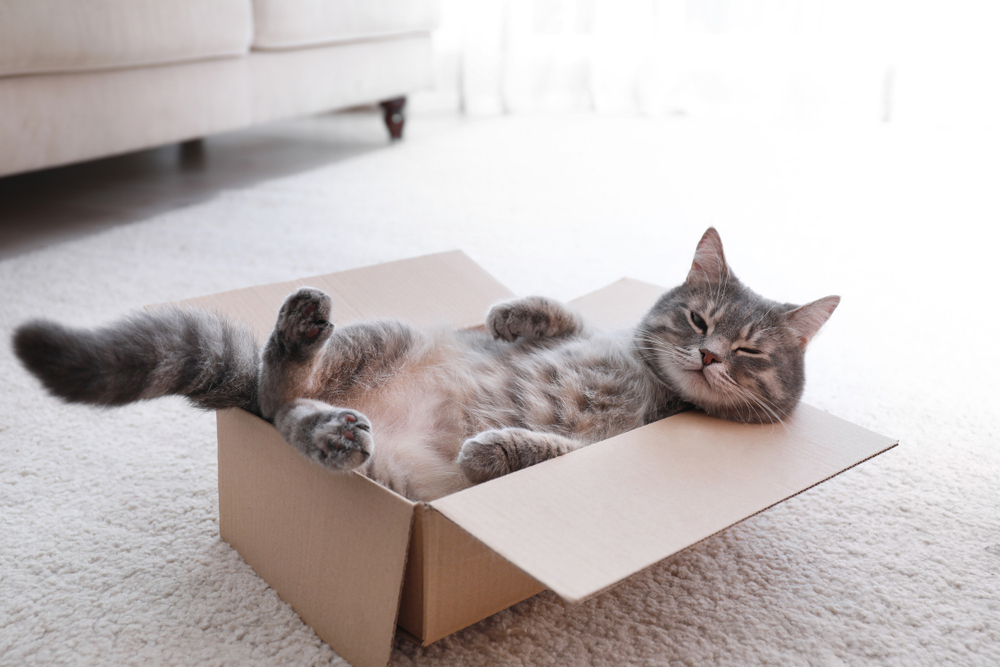

Answer:
[===start thinker===]
Well, it's a bit unusual that a cat is lying in a box. Cats usually don't do that. They prefer to be on the floor or on furniture. But it's not really unusual in the sense that it's a cat in a box. It's just that it's not something you see every day. What do you think about it?


In [ ]:
image_path = Path("cat.png")

if not image_path.exists():
    url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/d5fbbd1a-d484-415c-88cb-9986625b7b11"
    image = Image.open(BytesIO(requests.get(url).content))
    image.save(image_path)
else:
    image = Image.open(image_path)

print("Question:\nWhat is unusual on this picture?")
display(image)
print("Answer:")

conversation = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": "You are Qwen, a virtual human developed by the Qwen Team, Alibaba Group, capable of perceiving auditory and visual inputs, as well as generating text and speech.",
            }
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "cat.png"},
            {"type": "text", "text": "What is unusual on this picture?"},
        ],
    },
]
text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
audios, images, videos = process_mm_info(conversation, use_audio_in_video=False)
inputs = processor(text=text, images=images, videos=videos, return_tensors="pt", padding=True, use_audio_in_video=False)
text_ids = ov_model.generate(
    **inputs, stream_config=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True), return_audio=False, thinker_max_new_tokens=256
)

text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

### Audio-text input
[back to top ⬆️](#Table-of-contents:)

In [ ]:
if not Path("Trailer.wav").exists():
    download_file("https://voiceage.com/wbsamples/in_mono/Trailer.wav", "Trailer.wav")

audio = sf.read("Trailer.wav")

question = "Translate the audio to  French. "

conversation = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": "You are Qwen, a virtual human developed by the Qwen Team, Alibaba Group, capable of perceiving auditory and visual inputs, as well as generating text and speech.",
            }
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": question},
            {"type": "audio", "audio": "Trailer.wav"},
        ],
    },
]

print(f"Question:\n{question}")
display(IPython.display.Audio("Trailer.wav"))

print("Answer:")
text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)

audios, images, videos = process_mm_info(conversation, use_audio_in_video=True)
inputs = processor(text=text, audio=audios, return_tensors="pt", padding=True, use_audio_in_video=True)
text_ids = ov_model.generate(
    **inputs, stream_config=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True), return_audio=False, thinker_max_new_tokens=256
)

text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

Question:
Translate the audio to  French. 


Answer:
[===start thinker===]
Quoi qu'il en soit de votre format.


### Video-text input
[back to top ⬆️](#Table-of-contents:)

In [ ]:
if not Path("coco.mp4").exists():
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4",
        filename="coco.mp4",
    )

question = "Describe the video"

conversation = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": "You are Qwen, a virtual human developed by the Qwen Team, Alibaba Group, capable of perceiving auditory and visual inputs, as well as generating text and speech.",
            }
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": question},
            {"type": "video", "video": "coco.mp4"},
        ],
    },
]

print(f"Question:\n{question}")
display(IPython.display.Video("coco.mp4"))

print("Answer:")
text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)

audios, images, videos = process_mm_info(conversation, use_audio_in_video=False)
inputs = processor(text=text, videos=videos, return_tensors="pt", padding=True, use_audio_in_video=False)
text_ids = ov_model.generate(
    **inputs, stream_config=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True), return_audio=False, thinker_max_new_tokens=256
)

text = processor.batch_decode(text_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

Question:
Describe the video


Answer:


qwen-vl-utils using decord to read video.
Unused or unrecognized kwargs: return_tensors, images.


[===start thinker===]
The video shows a black dog on a leash. It's walking on a sidewalk next to a building. The dog has a collar on and is moving forward. The person holding the leash is partially visible, wearing blue jeans and brown shoes. The sidewalk has some leaves on it. It seems like a calm, outdoor setting. What do you think about the video?


## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_model, processor)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/